# FWI of the Volve synthetic data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
import torch

## Model, geometry, and data

In [2]:
# Load from input file
inputdata = np.load('../data/input_nofs_full_volvesynth.npz')

# Velocity 
vel = inputdata["vel"].T

# Smooth velocity
nsmooth = 41
smooth = np.ones(nsmooth)/nsmooth
velsm = filtfilt(smooth, 1, filtfilt(smooth, 1, vel).T).T
 
nx, nz = vel.shape
x = inputdata["x"]
z = inputdata["z"]
s = inputdata["s"]
r = inputdata["r"]
ns, nr = s.shape[1], r.shape[1]
nx, nz = x.size, z.size

# t = inputdata['t']
# dt = t[1]
# d = inputdata['p'].transpose(0, 2, 1)

In [3]:
# Convert from global to local grid
xorig = x[0]
x -= xorig
dx, dz = x[1], z[1]

s[0] -= xorig
r[0] -= xorig

In [4]:
# Create folder to save the results
folder_name = f'Results_VolveSynthetic'
if os.path.isdir(folder_name) is False:
    os.makedirs(folder_name)

In [5]:
par = {
        # model parameters
        'nx':480,   'dx':12.5,  'ox':0,
        'nz':360,   'dz':12.5,  'oz':0,
        'nr':180,   'dr':torch.tensor(r[0]),  'orec':0,  'rz':torch.tensor(r[1]),
        'num_shots':110,   'ds':torch.tensor(s[0]),  'os':0,  'sz':torch.tensor(s[1]),
        'nt':4702,  'dt':0.001,  'ot':0,
        'num_sources_per_shot': 1, 'num_receivers_per_shot': 180,
        'num_dims':2,
        'num_batches':110,
}

In [6]:
exp1 = 'Exp_VolveSynthetic_BB'
exp2 = 'Exp_VolveSynthetic_LBFGS'
exp3 = 'Exp_VolveSynthetic_dm'

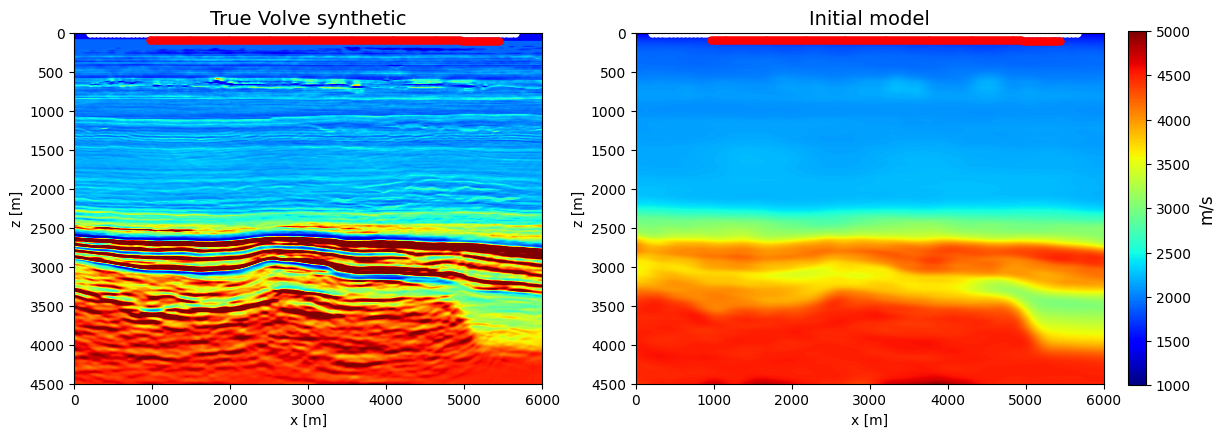

In [7]:
i = 2
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
im1 = axs[0].imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[0].plot(s[0], s[1], '.w', ms=10)
axs[0].plot(r[0], r[1], '.r', ms=10)
axs[0].set_title('True Volve synthetic', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[1].plot(s[0], s[1], '.w', ms=10)
axs[1].plot(r[0], r[1], '.r', ms=10)
axs[1].set_title('Initial model', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.46, pad=0.02).set_label(label='m/s',size=12)
plt.savefig(f'{folder_name}/volve_synth.png', bbox_inches='tight', dpi=300)

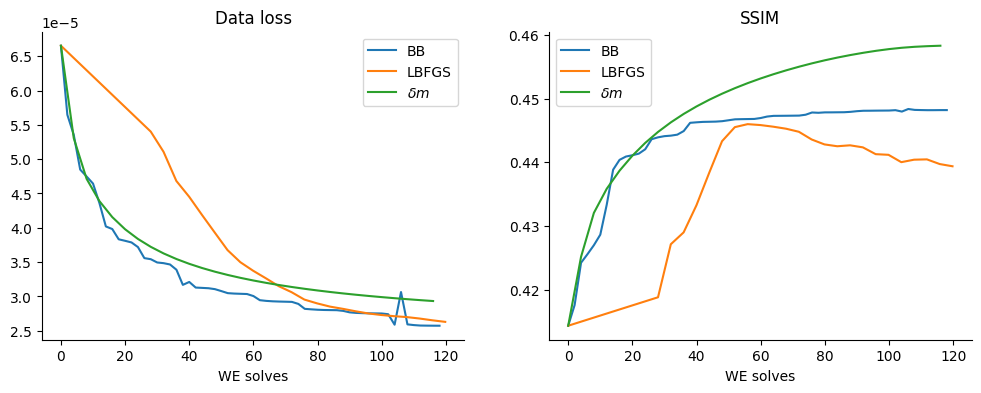

In [8]:
loss_bb = np.load(f'{exp1}/data_loss.npy')
loss_lbfgs = np.load(f'{exp2}/data_loss.npy')
loss_dm =  np.load(f'{exp3}/data_loss.npy')
ssim_bb = np.load(f'{exp1}/ssim.npy')
ssim_lbfgs = np.load(f'{exp2}/ssim.npy')
ssim_dm =  np.load(f'{exp3}/ssim.npy')
nWE = np.load(f'{exp2}/nWE.npy')

xaxis1 = np.arange(0, 120, 2)
xaxis2 = np.arange(0, 120, 4)
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(xaxis1, loss_bb, label='BB')
axs[0].plot(nWE[:25], loss_lbfgs[:25], label='LBFGS')
axs[0].plot(xaxis2, loss_dm[:50], label=r'$\delta m$')
axs[0].set_title('Data loss')
axs[0].set_xlabel('WE solves')
axs[0].legend()
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(xaxis1, ssim_bb, label='BB')
axs[1].plot(nWE[:-1][:25], ssim_lbfgs[:25], label='LBFGS')
axs[1].plot(xaxis2, ssim_dm, label=r'$\delta m$')
axs[1].set_title('SSIM')
axs[1].set_xlabel('WE solves')
axs[1].legend()
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{folder_name}/losses.png',  bbox_inches='tight', dpi=300)

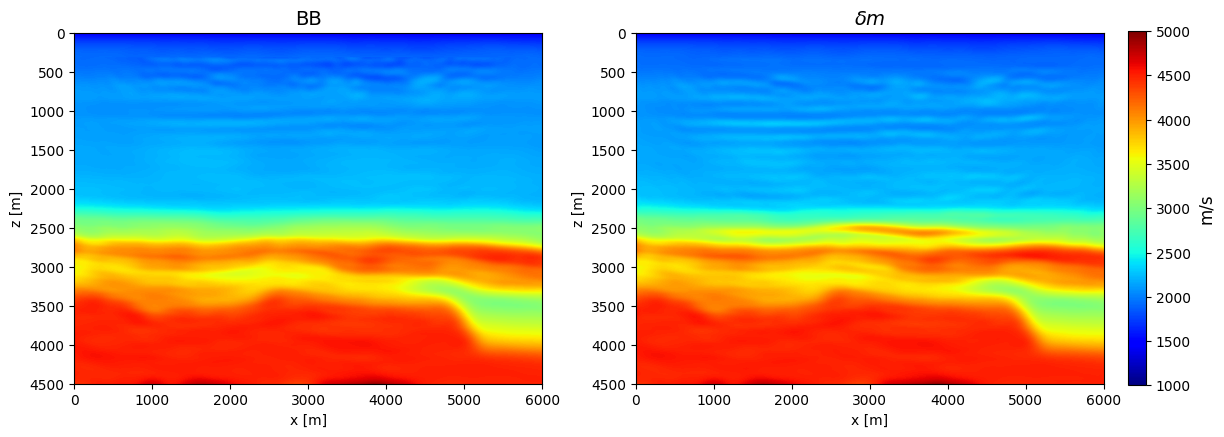

In [9]:
update_bb_3 = np.load(f'{exp1}/update_3.npy')
update_dm_3 = np.load(f'{exp3}/update_3.npy')
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
im1 = axs[0].imshow(update_bb_3, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[0].set_title('BB', fontsize=14)
axs[0].set_xlabel(r'x [m]')
axs[0].set_ylabel(r'z [m]')
im2 = axs[1].imshow(update_dm_3, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[1].set_title(r'$\delta m$', fontsize=14)
axs[1].set_xlabel(r'x [m]')
axs[1].set_ylabel(r'z [m]')
fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.46, pad=0.02).set_label(label='m/s',size=12)
plt.savefig(f'{folder_name}/volve_synth_third_iter', bbox_inches='tight', dpi=300)

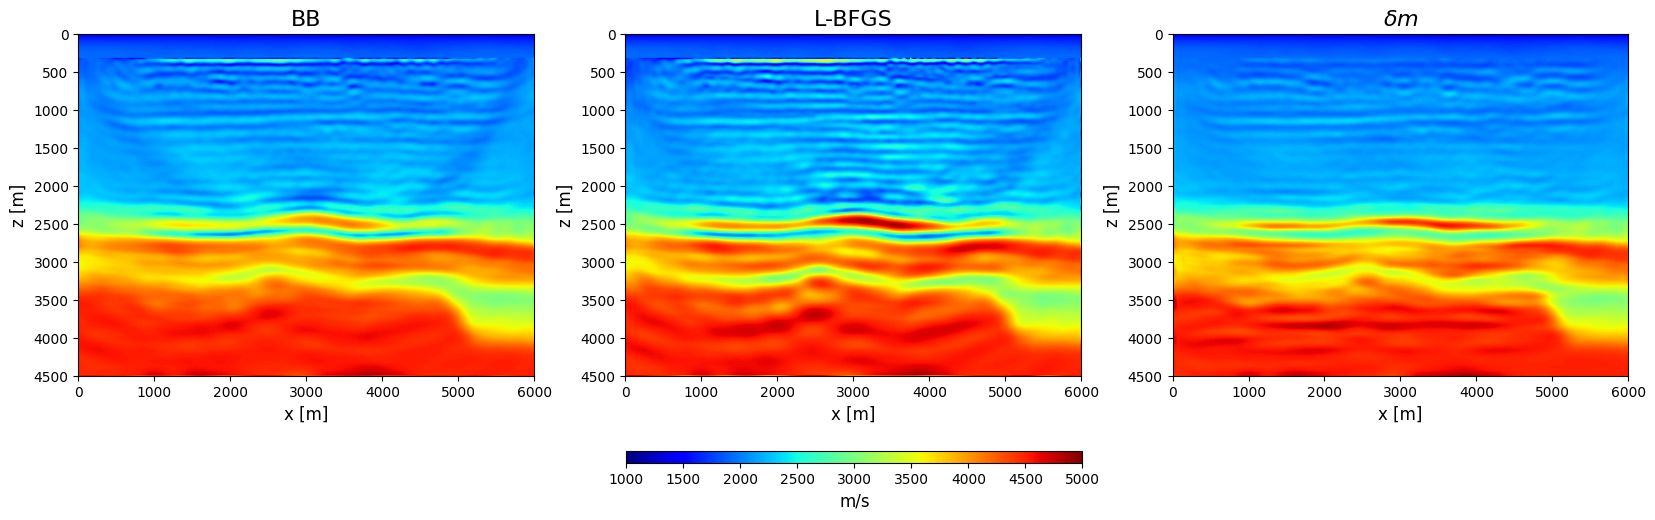

In [10]:
update_bb_last = np.load(f'{exp1}/update_last.npy')
update_lbfgs = np.load(f'{exp2}/update.npy')
update_dm_last = np.load(f'{exp3}/update_last.npy')

font_size = 16
font_size2 = 12
fig, axs = plt.subplots(1, 3, figsize=(20, 12))
im1 = axs[0].imshow(update_bb_last, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[0].set_title('BB', fontsize=font_size)
axs[0].set_xlabel(r'x [m]', fontsize=font_size2)
axs[0].set_ylabel(r'z [m]', fontsize=font_size2)
im2 = axs[1].imshow(update_lbfgs, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[1].set_title('L-BFGS', fontsize=font_size)
axs[1].set_xlabel(r'x [m]', fontsize=font_size2)
axs[1].set_ylabel(r'z [m]', fontsize=font_size2)
im3 = axs[2].imshow(update_dm_last, cmap='jet', vmin=1000, vmax=5000, 
                      extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs[2].set_title(r'$\delta m$', fontsize=font_size)
axs[2].set_xlabel(r'x [m]', fontsize=font_size2)
axs[2].set_ylabel(r'z [m]', fontsize=font_size2)
# Specify colorbar position [left, bottom, width, height]
cbar_ax = fig.add_axes([0.399, 0.28, 0.228, 0.01])
fig.colorbar(im3, cax=cbar_ax, ax=axs.ravel().tolist(), shrink=0.5, pad=0.02, orientation='horizontal').set_label(label='m/s',size=12)
plt.savefig(f'{folder_name}/volve_synth_one_iter_p', bbox_inches='tight', dpi=300)